# Resonator Q-factor fit

This notebook fit the Q-factor of the KTO resonator based on the following two-port circuit. 

This circuit is composed of two identical segements of transmission line, each characterized by the impedance $Z_1$ and propagation constant $\gamma = a+bj$, a central impedance element $Z$, and input and output impedances $Z_0$.

Each transmission line segment with impedance $Z_1$ and propagation constant $\gamma$ has the ABCD parameter matrix:
$$\begin{pmatrix}
\cosh(\gamma) & Z_1 \sinh(\gamma)\\
\frac{1}{Z_1} \sinh(\gamma) & \cosh(\gamma)
\end{pmatrix}$$

The middle impedance component has the ABCD parameter matrix:
$$\begin{pmatrix}
1&0\\ \frac{1}{Z} & 1
\end{pmatrix}$$


The total ABCD parameter matrix is obtained by multiply the ABCD parameters together. Then, the scattering parameter $S_{21}$ is obtained from the total ABCD parameter matrix:
$$S_{21} = \frac{2}{A +\frac{B}{Z_0}+C+DZ_0}=\frac{2ZZ_0Z_1}{\left(Z_0 \cosh(\gamma) + Z_1 \sinh(\gamma)\right) \left((2 Z + Z_0) Z_1\cosh(\gamma) + (2 Z Z_0 + Z1^2) \sinh(\gamma)\right)}$$



Near the resonant frequency $\omega_0$, the impedance $Z$ is approximated as $Z\approx R+2\Delta \omega L j$. Thus, the effective resistance and inductance can be read from the $S_{21}$ curve. Finally, the internal Q-factor $Q_0 = \frac{\omega L}{R}$ is obtained.  

![circuit_diagram](circuit_diagram.png)

In [2]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from scipy.optimize import minimize

import q_factor_lib as qfl

B=0.010000000000000009  T=0.02001665312758595


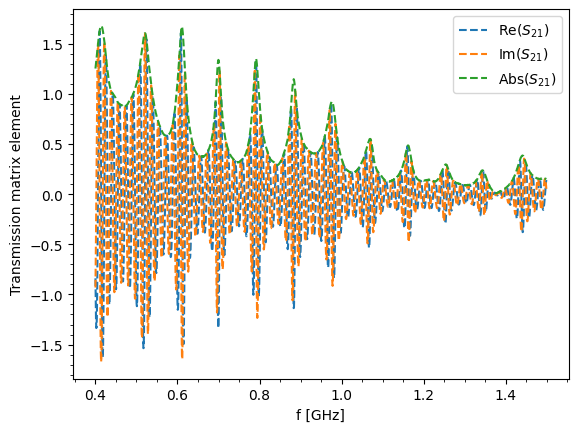

In [8]:
B,T,df=qfl.read_data("./experiment_results.tdms")

print(f'B={B}  T={T}')
fig,ax=plt.subplots()
qfl.plot_data(df,'S21',ax)
plt.show()

Fast Oscillation Freq:  -5.996252342286071e-08


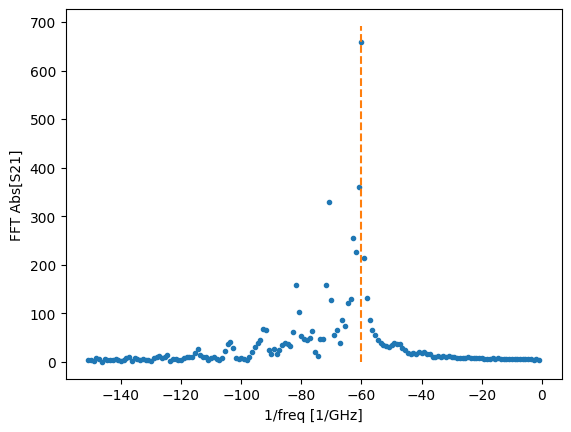

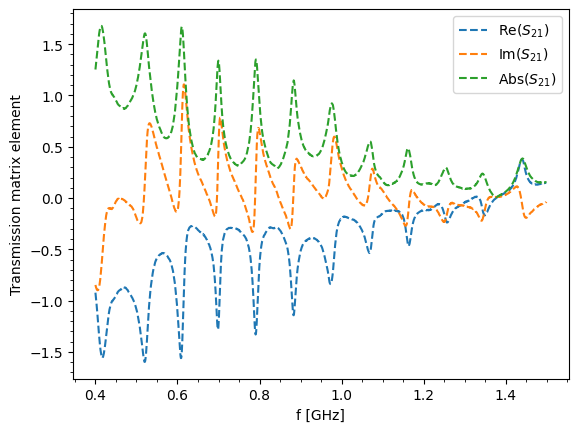

In [11]:
qfl.remove_fast_osc(df)

fig,ax=plt.subplots()
qfl.plot_data(df,'S21_filtered',ax)
plt.show()

In [12]:
pos_res=np.argmin(np.abs(df['S21_filtered']))
print(f'Resonance freq={df['freq'][pos_res]/1E9} GHz')
pos_res

Resonance freq=1.3769375 GHz


np.int64(1421)

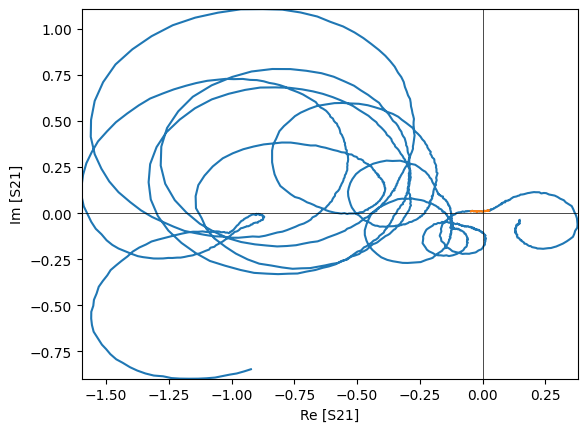

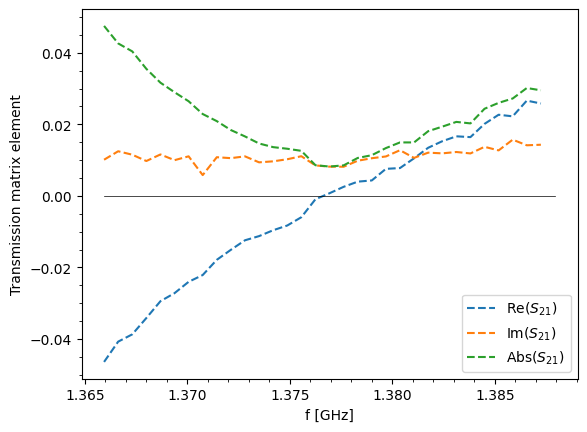

In [27]:
s1=pos_res-16
s2=pos_res+16

fig,ax=plt.subplots()
qfl.plot_circles(df, 'S21_filtered', ax, s1, s2)
plt.show()

fig,ax=plt.subplots()
qfl.plot_data(df,'S21_filtered',ax, select=[s1,s2], plot_axis=True)
plt.show()

In [28]:
S21_filtered_s = np.array(df['S21_filtered'][s1:s2])
ang_freq_s = np.array(df['freq'][s1:s2]/1E9)*2*np.pi

idx=np.argmin(np.abs(S21_filtered_s))
w0 = ang_freq_s[idx]
dw = ang_freq_s-w0

Rt = .1
Lt  = 1
a = 1
b = 10
Z1_r = 10
Z1_i = 10
# Try different initial parameters to get the best fit

initial_params = [Rt,Lt,a,b,Z1_r,Z1_i]

result = minimize(qfl.loss_function, initial_params, args=((dw,w0),np.conj(S21_filtered_s)),bounds = [(1e-6,None),(None,None),(1e-6,None),(None,None),(1e-6,None),(None,None)],
                  method='Nelder-Mead', options={'maxiter': 10000})
# We need to fit the complex conjugate of the S21 curve. Probabily because of mismatch of the direction in experiment and simulation.

print(result.success,result.x)
print("Q = " + str(w0*result.x[1]/result.x[0]))
print("loss = " + str(result.fun))


True [ 0.17952004  4.81436222  0.64923953 10.52604184  0.0367366   8.02871641]
Q = 232.01705673244348
loss = 0.055825569963968466


In [29]:
S_fit = qfl.model_function(fix_arg=(dw,w0), params =result.x)

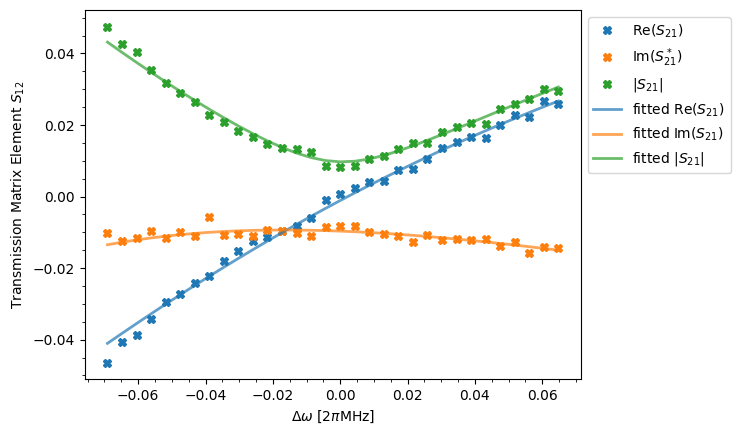

In [30]:
fig,ax=plt.subplots()

ax.set_xlabel(r'$\Delta \omega$ [2$\pi$MHz]')
ax.set_ylabel(r'Transmission Matrix Element $S_{12}$')

ax.plot(dw,np.real(S21_filtered_s),'X',label = r"Re$(S_{21})$", color='C0')
ax.plot(dw,-np.imag(S21_filtered_s),'X',label = r"Im$(S_{21}^*)$", color='C1')
ax.plot(dw,np.abs(S21_filtered_s),'X',label = r"$|S_{21}|$", color='C2')

ax.plot(dw,np.real(S_fit),'-',label = r"fitted Re$(S_{21})$",linewidth = 2,alpha = 0.7, color='C0')
ax.plot(dw,np.imag(S_fit),'-',label = r"fitted Im$(S_{21})$",linewidth = 2,alpha = 0.7, color='C1')
ax.plot(dw,np.abs(S_fit),'-',label = r"fitted $|S_{21}|$",linewidth = 2,alpha = 0.7, color='C2')


ax.minorticks_on()
ax.legend(bbox_to_anchor=(1., 1.))

plt.show()